<a href="https://colab.research.google.com/github/haji8-de/AIFFEL_quest_rs/blob/main/Exploration/Ex03/ablation_study_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 60.5MB/s]


In [3]:
# 데이터의 개수도 확인해 봅시다.
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 50000 (Shape: torch.Size([]))
Test dataset size: 10000 (Shape: torch.Size([]))


In [4]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 Pytorch 정규화 코드를 작성해봅시다.
transform = transforms.Compose([
    transforms.ToTensor()  # uint8 → float32 변환 + 0~1 정규화
    # 이미지 픽셀 값을 255로 나누어 0과 1 사이로 정규화하기 위해 transforms.ToTensor()를 사용한다.
])

In [5]:
num_classes = len(trainset.classes)
print(num_classes)

10


In [6]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [8]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

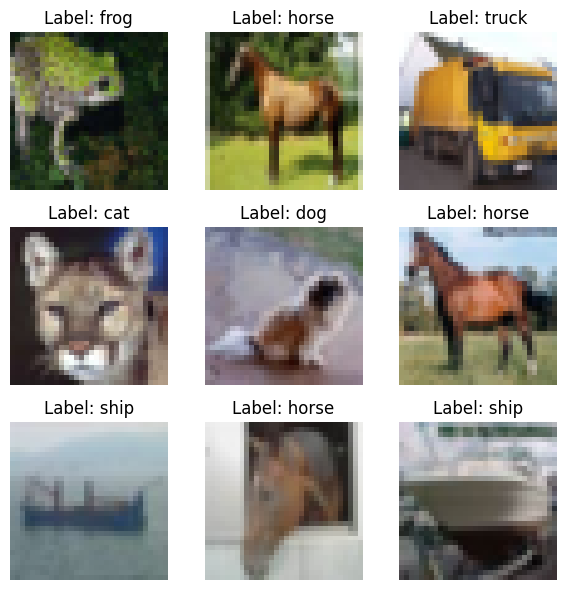

In [9]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

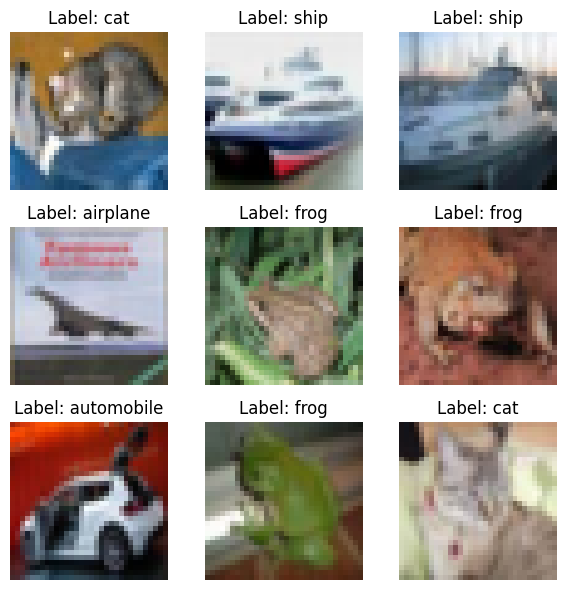

In [10]:
# 테스트 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(testloader)

## Ablation Study 실습 (2) 블록 구성하기

In [11]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    layers = []
    in_channels = x.size(1)
    for cnn_num in range(num_cnn):
        layers.append(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=channel,
                kernel_size=3,
                stride=1,
                padding=1,
            )
        )
        layers.append(nn.ReLU(inplace=True))
        in_channels = channel

    # Max Pooling 레이어
    layers.append(
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )

    # Sequential으로 레이어 묶기
    block = nn.Sequential(*layers)
    return block

In [12]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        # VGG 블록 생성
        self.vgg_block = build_vgg_block(torch.zeros(1, 3, 32, 32))
    def forward(self, x):
        return self.vgg_block(x)

In [27]:
# 블록 1개짜리 model 생성
model = VGGNet()
print(model)

dummy_input = torch.zeros(1, 3, 32, 32)
output = model(dummy_input)
print(output.shape)


VGGNet(
  (vgg_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([1, 64, 16, 16])


In [14]:
# VGG 모델 자체를 생성하는 클래스입니다.
class VGG(nn.Module):
    def __init__(self, num_cnn_list=[2, 2, 3, 3, 3], channel_list=[64, 128, 256, 512, 512], num_classes=10):
        super(VGG, self).__init__()
        assert len(num_cnn_list) == len(channel_list), "num_cnn_list와 channel_list의 길이가 일치해야 합니다."

        layers = []
        in_channels = 3

        for num_cnn, out_channels in zip(num_cnn_list, channel_list):
            layers.append(self._make_vgg_block(in_channels, out_channels, num_cnn))
            in_channels = out_channels  # 다음 블록의 입력 채널을 설정

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes)
        )

    def _make_vgg_block(self, in_channels, out_channels, num_cnn):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.ReLU(True)]
        for _ in range(num_cnn - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(True))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Max Pooling 추가
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [15]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.

vgg_16 = VGG()
print(vgg_16)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [16]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = VGG(
    num_cnn_list=[2, 2, 4, 4, 4],
    channel_list=[64, 128, 256, 512, 512]
)
print(vgg_19)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [18]:
# Q. VGG-16보다 작은 네트워크인 VGG-13을 만들어 보세요.
def build_vgg13(num_classes=10):
    return VGG(
        num_cnn_list=[2, 2, 2, 2, 2],
        channel_list=[64, 128, 256, 512, 512],
        num_classes=num_classes
    )

In [19]:
vgg_13 = build_vgg13()
print(vgg_13)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [32]:
vgg_19.classifier[5] = nn.Linear(4096, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
# Assuming 'vgg_19' is the intended model for training.
model = vgg_19.to(device)
criterion = nn.CrossEntropyLoss().to(device)
# 'hyperparams' variable is not defined, which would cause a NameError.
# You need to define 'hyperparams' or set a learning rate directly.
# For example: optimizer = optim.SGD(model.parameters(), lr=0.001)
# Replacing with a placeholder learning rate for now.
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5):
    cost = 0.0

    for images, classes in trainloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        loss = criterion(output, classes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss

    cost = cost / len(trainloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

In [ ]:

with torch.no_grad():
    model.eval()

    accuracy = 0.0
    for images, classes in testloader:
        images = images.to(device)
        classes = classes.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=-1)
        outputs_classes = torch.argmax(probs, dim=-1)

        accuracy += int(torch.eq(classes, outputs_classes).sum())

    print(f"acc@1 : {accuracy / (len(testloader) * 4) * 100:.2f}%")

In [ ]:
outputs = model(testloader[0][0])